In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys

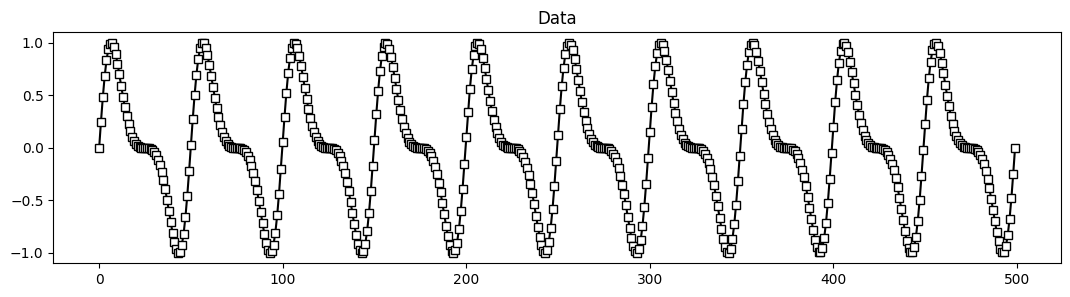

In [2]:
# make the data
N = 500

# data 2
time = torch.linspace(0, 20 * np.pi, N)  # t : 0->20pi
data = torch.sin(time + torch.sin(time))  # sin(t+sin(t))

plt.figure(figsize=(13, 3))
plt.plot(data, "ks-", label="data", markerfacecolor="w")
plt.title("Data")

plt.show()

In [3]:
# network parameters
input_size = 1  # "channels" of data
num_hidden = 9  # breadth of model (number of units in hidden layers)
num_layers = 1  # depth of model (number of "stacks" of hidden layers)
batchsize = 1   # Note: the training code is actually hard-coded to organize data into batchsize=1

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # RNN Layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)
        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):
        # run through the RNN layer
        y, hidden = self.rnn(x)
        # and the output (linear) layer
        y = self.out(y)

        return y, hidden.detach()

In [5]:
def train_a_model(seqlength, numepochs=50):

    # create a new instance of the model (and optimizer!)
    net = RNN(input_size, num_hidden, num_layers)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
    lossfun = nn.MSELoss()

    # loop over epochs
    for epochi in range(numepochs):

        for timei in range(N - seqlength):

            # grab a snippet of data
            X = data[timei : timei + seqlength].view(seqlength, 1, 1)
            y = data[timei + seqlength].view(1, 1)

            # forward pass and loss
            yHat, hiddenstate = net(X)
            finalValue = yHat[-1]
            loss = lossfun(finalValue, y)  # compare final value of output

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        sys.stdout.write("\r"+f"SeqLen : {seqlength}; epoch : {epochi+1}/{numepochs}")

    return net

In [6]:
def forcast(model, seqlength, n=100):
# given n points, forcasting next n time points
    yHat = torch.zeros(2 * n)
    yHat[:] = torch.nan
    yHat[:n] = data[:n]

    # forcast
    for timei in range(2 * n - seqlength):
        X = yHat[timei : timei + seqlength].view(seqlength, 1, 1)
        predValue = model(X)[0][-1]
        if yHat[timei + seqlength].isnan():
            yHat[timei + seqlength] = predValue

    # plot
    plt.figure(figsize=(12, 3))
    plt.plot(yHat.detach(), "ro-", label="Predicted", markersize=5)
    plt.plot(data[:n].detach(), "bo-", label="Actual data", markersize=6)
    plt.title("Forecasting with sequence length " + str(seqlength))
    plt.legend()
    plt.show()

    return yHat[n:]

SeqLen : 10; epoch : 50/50

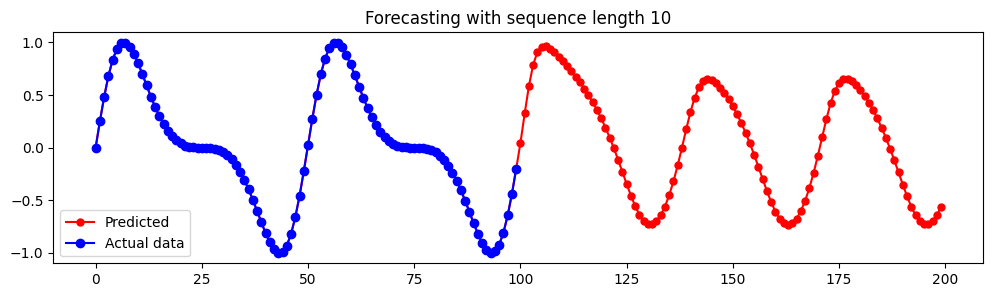

SeqLen : 20; epoch : 50/50

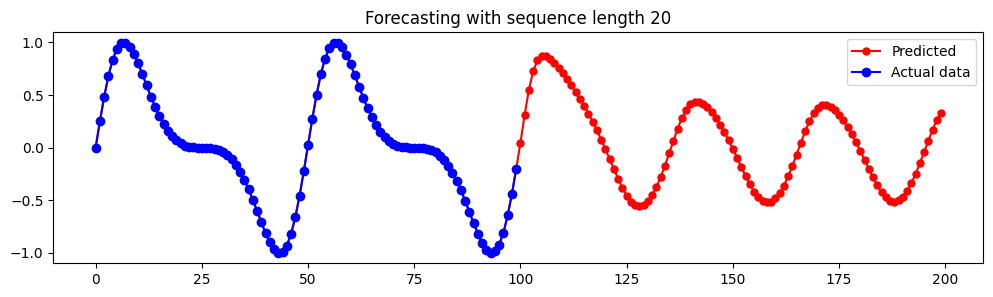

SeqLen : 30; epoch : 50/50

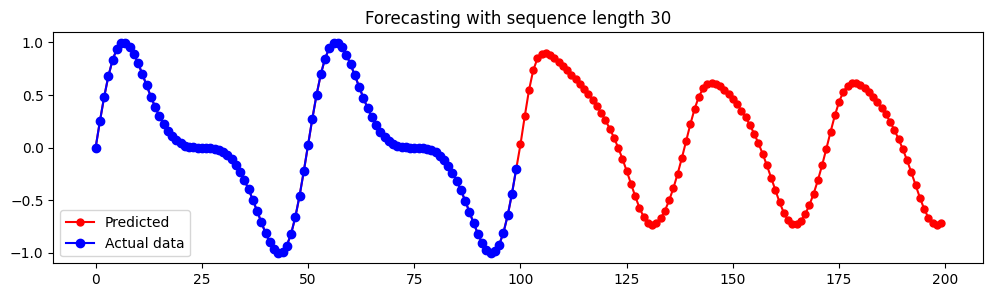

SeqLen : 40; epoch : 50/50

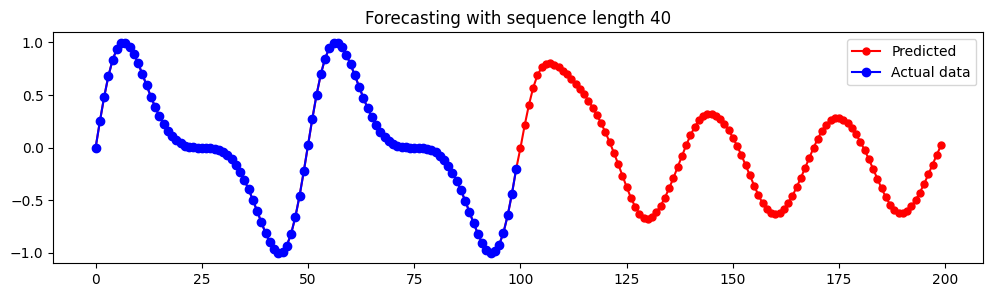

SeqLen : 50; epoch : 50/50

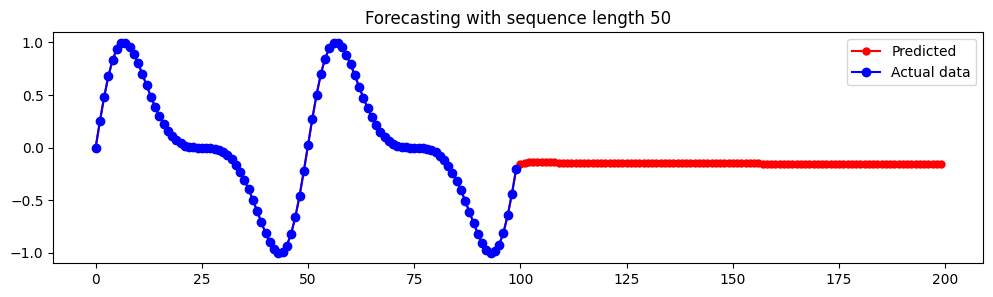

SeqLen : 60; epoch : 50/50

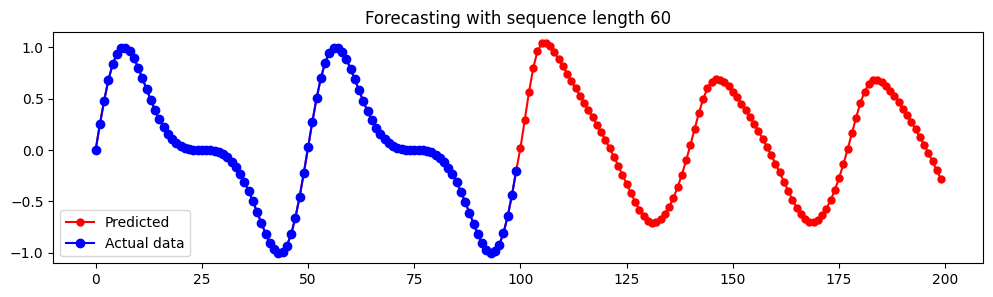

SeqLen : 70; epoch : 50/50

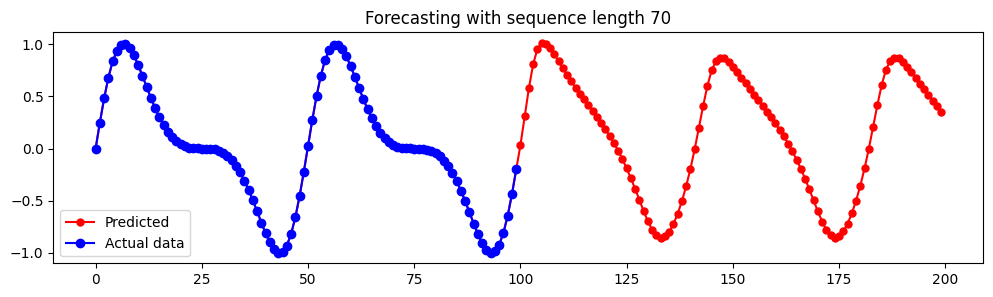

SeqLen : 80; epoch : 50/50

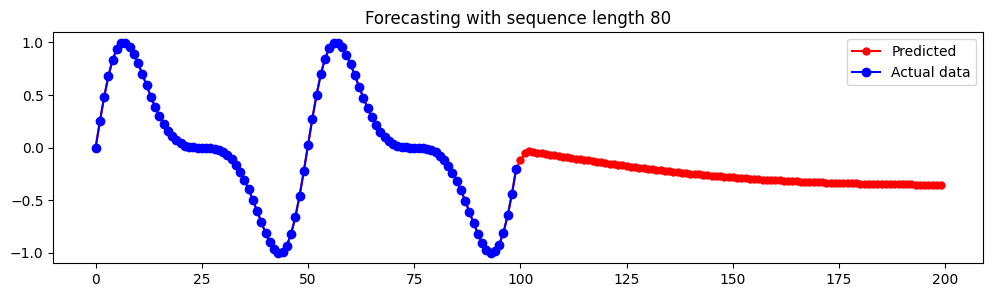

SeqLen : 90; epoch : 50/50

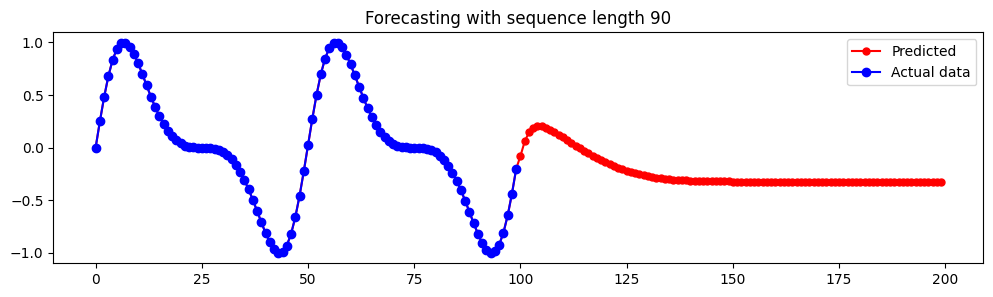

SeqLen : 100; epoch : 50/50

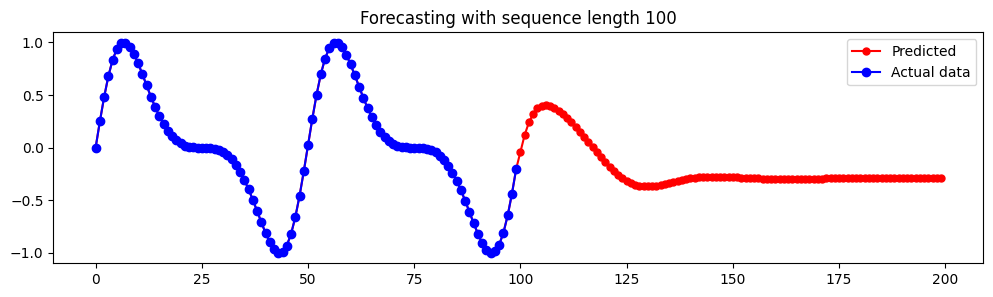

In [14]:
n = 100
seq_lengths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
errors = []
for seqlength in seq_lengths:
    model = train_a_model(seqlength, numepochs=50)
    yHat = forcast(model, seqlength, n)
    # compare with real data
    real = data[n : n * 2]
    error = torch.mean(torch.abs(real - yHat)).detach()
    errors.append(error)
    # print(error)

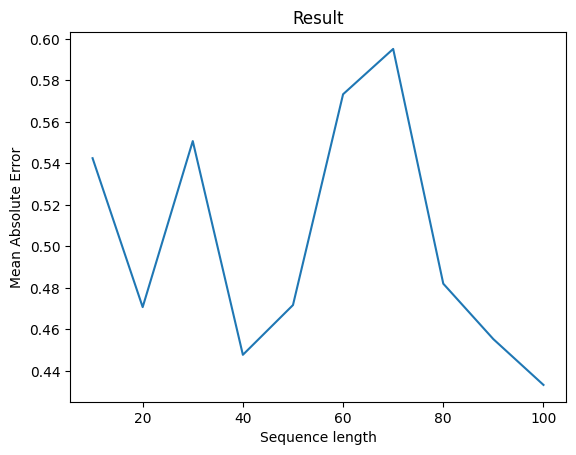

In [15]:
# plot
plt.plot(seq_lengths, errors)
plt.title("Result")
plt.xlabel("Sequence length")
plt.ylabel("Mean Absolute Error")
plt.show()